In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
import ast
from matplotlib.lines import Line2D

In [3]:
OPTION = 1
if OPTION == 1:
    model_name = 'vgg16_without_model'
    data_metrics_file = 'dataset_info_parts_metrics_methods_without'
else:
    model_name = 'vgg16_model'
    data_metrics_file = 'dataset_info_parts_metrics_methods'
mis_file = 'mis_stats_'+str(OPTION)+'.csv'

In [4]:
df = pd.read_csv(data_metrics_file+'.csv')

# Performance metrics

In [5]:
# Asegurar tipo correcto
df['pred_ok'] = df['pred_ok'].astype(int)

# Filtrar por método gradcam y sin oclusión (oc_part == NaN) - Sólo un tipo 537 imágenes
df_filtered = df[(df['method'] == 'gradcam') & (df['oc_part'].isna())]
df_filtered.shape

(537, 28)

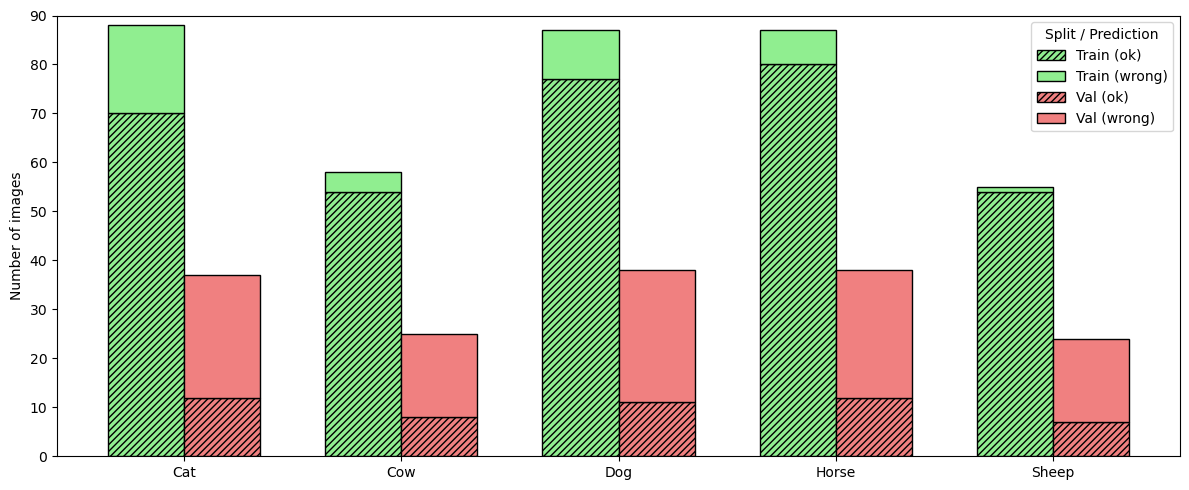

In [6]:
grouped = df_filtered.groupby(['cat', 'split', 'pred_ok']).size().unstack(fill_value=0)

# Asegurarse de que existan columnas 0 (fallos) y 1 (aciertos)
if 0 not in grouped.columns:
    grouped[0] = 0
if 1 not in grouped.columns:
    grouped[1] = 0

# Reordenar columnas: [1 (aciertos), 0 (fallos)]
grouped = grouped[[1, 0]]

# Preparar datos
cats = grouped.index.get_level_values(0).unique()
splits = grouped.index.get_level_values(1).unique()

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

bar_width = 0.35
x = range(len(cats))

# Posiciones para cada split
x_pos = {
    split: [i + (j * bar_width) for i, j in zip(range(len(cats)), [0 if split == 'train' else 1 for _ in range(len(cats))])]
    for split in splits
}

# Colores
colors = {'train': 'lightgreen', 'val': 'lightcoral'}

# Dibujar barras: aciertos abajo, fallos arriba
for split in splits:
    successes = []
    fails = []
    for cat in cats:
        val_success = grouped.loc[(cat, split)][1] if (cat, split) in grouped.index else 0
        val_fail = grouped.loc[(cat, split)][0] if (cat, split) in grouped.index else 0
        successes.append(val_success)
        fails.append(val_fail)

    # Aciertos abajo con trama
    ax.bar(
        x_pos[split], successes, width=bar_width,
        color=colors[split], hatch='/////', label=f'{split.capitalize()} (ok)', edgecolor='black'
    )

    # Fallos encima
    ax.bar(
        x_pos[split], fails, bottom=successes, width=bar_width,
        color=colors[split], label=f'{split.capitalize()} (wrong)', edgecolor='black'
    )

# Estética
ax.set_xticks([i + bar_width / 2 for i in range(len(cats))])
ax.set_xticklabels([cat.capitalize() for cat in cats], rotation=0)
ax.set_ylabel('Number of images')
#ax.set_title('Distribución de aciertos (///) y fallos por categoría y partición')
#ax.grid(axis='x')
ax.set_ylim(0,90)

# Eliminar duplicados en leyenda
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Split / Prediction')

plt.tight_layout()
#plt.savefig('images/xai_performance_'+str(OPTION)+'_prediction_correct.png')
plt.show()


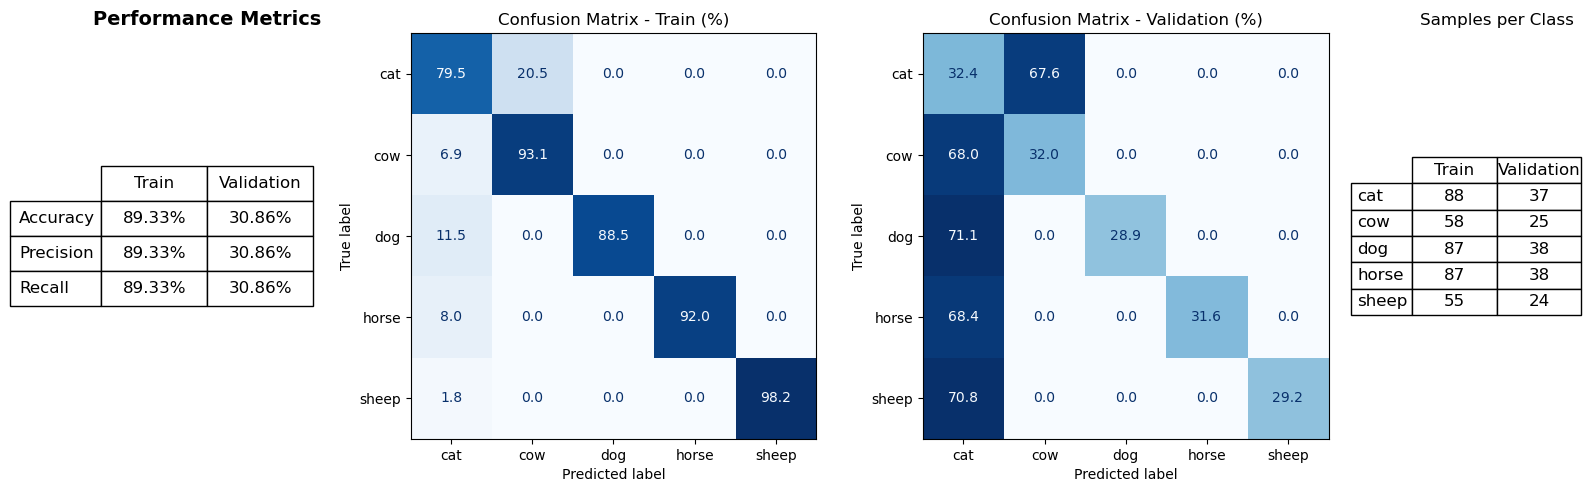

In [7]:
# Lista ordenada de categorías
labels = sorted(df_filtered['cat'].unique())

# Construimos la predicción simulada
def pred_simulada(row):
    if row['pred_ok']:
        return row['cat']
    else:
        otras = [c for c in labels if c != row['cat']]
        return otras[0] if otras else row['cat']

df_filtered = df_filtered.copy()
df_filtered.loc[:, 'pred'] = df_filtered.apply(pred_simulada, axis=1)

# Separamos train y val
df_train = df_filtered[df_filtered['split'] == 'train']
df_val = df_filtered[df_filtered['split'] == 'val']

# Matrices de confusión absolutas
cm_train_abs = confusion_matrix(df_train['cat'], df_train['pred'], labels=labels)
cm_val_abs = confusion_matrix(df_val['cat'], df_val['pred'], labels=labels)

# Normalizamos por filas (por clase verdadera): porcentaje
cm_train_pct = cm_train_abs.astype('float') / cm_train_abs.sum(axis=1, keepdims=True)
cm_val_pct = cm_val_abs.astype('float') / cm_val_abs.sum(axis=1, keepdims=True)

# Métricas globales (micro average)
metrics = {
    'Accuracy': [
        accuracy_score(df_train['cat'], df_train['pred']),
        accuracy_score(df_val['cat'], df_val['pred'])
    ],
    'Precision': [
        precision_score(df_train['cat'], df_train['pred'], labels=labels, average='micro', zero_division=0),
        precision_score(df_val['cat'], df_val['pred'], labels=labels, average='micro', zero_division=0)
    ],
    'Recall': [
        recall_score(df_train['cat'], df_train['pred'], labels=labels, average='micro', zero_division=0),
        recall_score(df_val['cat'], df_val['pred'], labels=labels, average='micro', zero_division=0)
    ]
}

# Formateamos métricas como porcentaje
for key in metrics:
    metrics[key] = [f"{v*100:.2f}%" for v in metrics[key]]

# Número de muestras por clase en validación
val_counts = df_val['cat'].value_counts().reindex(labels).fillna(0).astype(int)

# Crear figura con 4 columnas
fig, axs = plt.subplots(1, 4, figsize=(16, 5), gridspec_kw={'width_ratios': [0.75, 1.5, 1.5, 0.5]})

# 1ª columna: tabla de métricas
axs[0].axis('off')
row_labels = list(metrics.keys())
col_labels = ['Train', 'Validation']
table_data = [metrics[metric] for metric in row_labels]

table = axs[0].table(cellText=table_data, rowLabels=row_labels, colLabels=col_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
axs[0].set_title('Performance Metrics', fontsize=14, fontweight='bold')

# 2ª columna: matriz de confusión normalizada (train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=(cm_train_pct * 100), display_labels=labels)
disp_train.plot(ax=axs[1], cmap='Blues', colorbar=False, values_format=".1f")
axs[1].set_title('Confusion Matrix - Train (%)')

# 3ª columna: matriz de confusión normalizada (val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=(cm_val_pct * 100), display_labels=labels)
disp_val.plot(ax=axs[2], cmap='Blues', colorbar=False, values_format=".1f")
axs[2].set_title('Confusion Matrix - Validation (%)')

# 4ª columna: número total por clase (train y val)
axs[3].axis('off')

# Conteos por clase
train_counts = df_train['cat'].value_counts().reindex(labels).fillna(0).astype(int)
val_counts = df_val['cat'].value_counts().reindex(labels).fillna(0).astype(int)

count_table_data = [[train_counts[label], val_counts[label]] for label in labels]

count_table = axs[3].table(
    cellText=count_table_data,
    rowLabels=labels,
    colLabels=['Train', 'Validation'],
    cellLoc='center',
    loc='center'
)
count_table.auto_set_font_size(False)
count_table.set_fontsize(12)
count_table.scale(1.2, 1.5)
axs[3].set_title('Samples per Class', fontsize=12)#, fontweight='bold')

plt.tight_layout()
plt.savefig('images/xai_performance_'+str(OPTION)+'_confusion_matrix_metrics.png')
plt.show()

# Information-based Metrics

In [8]:
df_mis = pd.read_csv(mis_file)
def rename_dense(layer_name):
    if layer_name == 'dense':
        return 'dense_1'
    elif layer_name == 'dense_1':
        return 'dense_2'
    elif layer_name == 'dense_2':
        return 'dense_softmax'
    else:
        return layer_name

df_mis['layer'] = df_mis['layer'].apply(rename_dense)

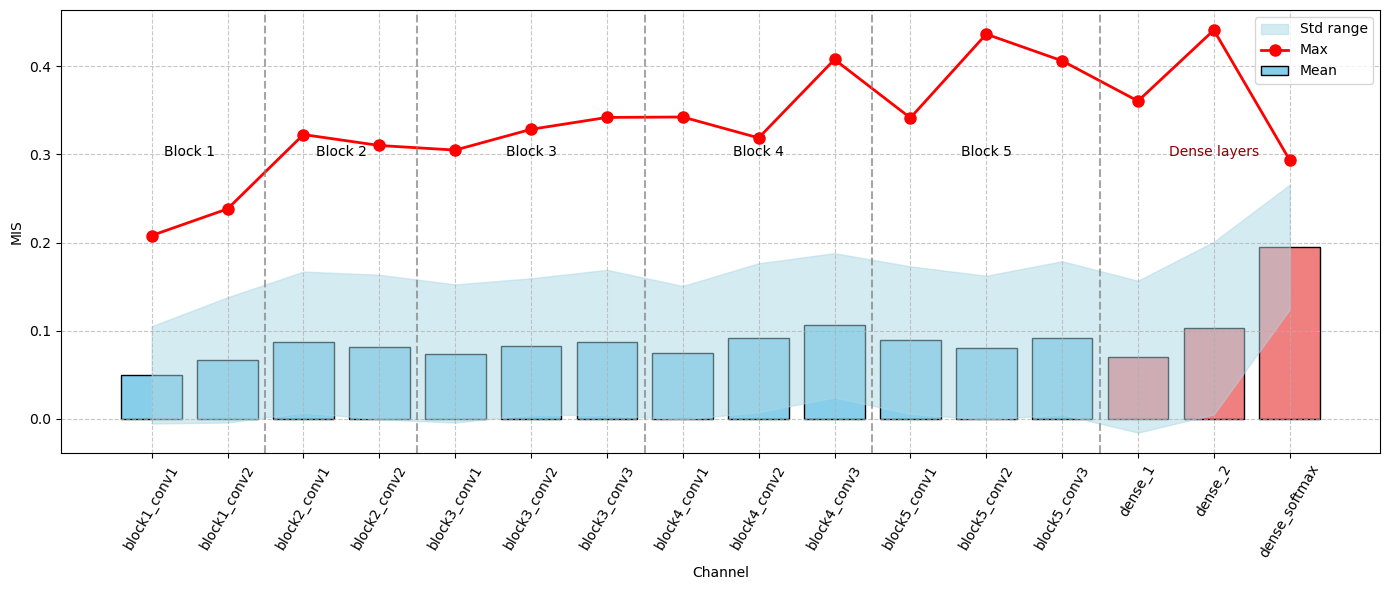

In [9]:
plt.figure(figsize=(14,6))

x = range(len(df_mis))
mean = df_mis['mean']
std = df_mis['std']
max_ = df_mis['max']

# Definimos los límites de cada bloque según número de capas
blocks = {
    'Block 1': 2,
    'Block 2': 2,
    'Block 3': 3,
    'Block 4': 3,
    'Block 5': 3,
}
total_conv_layers = sum(blocks.values())
dense_start_idx = total_conv_layers  # índice donde empiezan las densas

# Colores para conv y dense
colors = ['skyblue'] * total_conv_layers + ['lightcoral'] * (len(df_mis) - total_conv_layers)

plt.bar(x, mean, color=colors, edgecolor='black', label='Mean')
plt.fill_between(x, mean - std, mean + std, color='lightblue', alpha=0.5, label='Std range')
plt.plot(x, max_, color='red', marker='o', linestyle='-', linewidth=2, markersize=8, label='Max')

plt.xticks(x, df_mis['layer'], rotation=60)
plt.xlabel('Channel')
plt.ylabel('MIS')
plt.grid(True, linestyle='--', alpha=0.7)

# Añadir líneas verticales para separar bloques conv y la línea entre conv y dense
cumulative_layers = 0
for i, (block_name, num_layers) in enumerate(blocks.items()):
    cumulative_layers += num_layers
    # Línea vertical para separar bloques conv y entre conv y dense
    plt.axvline(cumulative_layers - 0.5, color='gray', linestyle='--', alpha=0.7)

# Añadir etiquetas centrales para cada bloque conv
start_idx = 0
for block_name, num_layers in blocks.items():
    center_pos = start_idx + num_layers / 2 - 0.5
    plt.text(center_pos, max(mean) + 0.1, block_name, ha='center', va='bottom', fontsize=10, color='black')
    start_idx += num_layers

# Etiqueta para capas densas
plt.text(dense_start_idx + (len(df_mis) - dense_start_idx)/2 - 0.5, max(mean) + 0.1, 'Dense layers', ha='center', va='bottom', fontsize=10, color='darkred')

plt.legend()
plt.tight_layout()
plt.show()

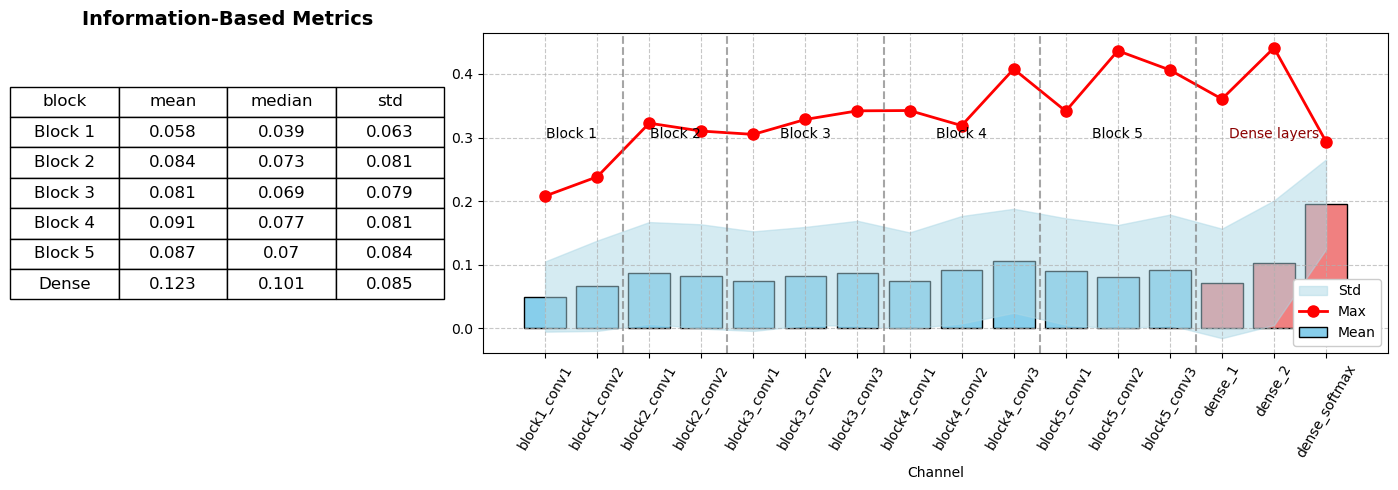

In [10]:
# Asignar cada capa a su bloque
blocks = {
    'Block 1': 2,
    'Block 2': 2,
    'Block 3': 3,
    'Block 4': 3,
    'Block 5': 3,
}

block_names = []
cumulative_layers = 0
block_limits = []
for block_name, num_layers in blocks.items():
    block_limits.append((cumulative_layers, cumulative_layers + num_layers))
    cumulative_layers += num_layers

for i in range(len(df_mis)):
    for block_name, (start, end) in zip(blocks.keys(), block_limits):
        if start <= i < end:
            block_names.append(block_name)
            break
    else:
        block_names.append('Dense')

df_mis['block'] = block_names

# Agrupar por bloque y calcular medias
df_block_stats = df_mis.groupby('block')[['mean', 'median', 'std']].mean().round(3).reset_index()

# Crear figura
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 2.5]})

# --- Tabla de estadísticas por bloque ---
axs[0].axis('off')

# Crear tabla con estadísticas
table = axs[0].table(cellText=df_block_stats.values,
                     colLabels=df_block_stats.columns,
                     cellLoc='center',
                     loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2.2)

axs[0].set_title('Information-Based Metrics', fontsize=14, fontweight='bold')

# --- Gráfico a la derecha ---
x = range(len(df_mis))
mean = df_mis['mean']
std = df_mis['std']
max_ = df_mis['max']

total_conv_layers = sum(blocks.values())
colors = ['skyblue'] * total_conv_layers + ['lightcoral'] * (len(df_mis) - total_conv_layers)

axs[1].bar(x, mean, color=colors, edgecolor='black', label='Mean')
axs[1].fill_between(x, mean - std, mean + std, color='lightblue', alpha=0.5, label='Std')
axs[1].plot(x, max_, color='red', marker='o', linestyle='-', linewidth=2, markersize=8, label='Max')

axs[1].set_xticks(x)
axs[1].set_xticklabels(df_mis['layer'], rotation=60)
axs[1].set_xlabel('Channel')
axs[1].grid(True, linestyle='--', alpha=0.7)

# Líneas entre bloques
cumulative_layers = 0
for block_name, num_layers in blocks.items():
    cumulative_layers += num_layers
    axs[1].axvline(cumulative_layers - 0.5, color='gray', linestyle='--', alpha=0.7)

# Etiquetas de bloques
start_idx = 0
for block_name, num_layers in blocks.items():
    center_pos = start_idx + num_layers / 2 - 0.5
    axs[1].text(center_pos, max(mean) + 0.1, block_name, ha='center', va='bottom', fontsize=10)
    start_idx += num_layers

axs[1].text(total_conv_layers + (len(df_mis) - total_conv_layers)/2 - 0.5,
            max(mean) + 0.1, 'Dense layers', ha='center', va='bottom', fontsize=10, color='darkred')

axs[1].legend(loc='lower right', framealpha=1)
plt.tight_layout()
plt.savefig('images/xai_information_'+str(OPTION)+'_mis_metrics.png')
plt.show()

# Robustness

robustness = performance(occlusion)/base --> similar a ESR

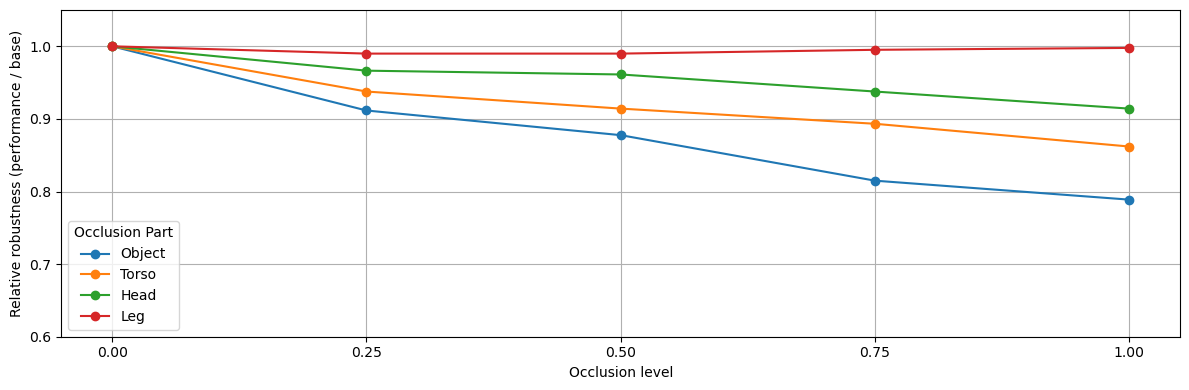

In [11]:
# Valores posibles de porcentaje de oclusión (excepto 0)
occlusion_levels = [0.25, 0.5, 0.75, 1]
parts = ['object', 'torso', 'head', 'leg']

# Media de pred_ok para occlusion 0 (oc_part == NaN)
base = df[df['oc_part'].isna()]['pred_ok'].mean()

plt.figure(figsize=(12,4))

for part in parts:
    df_part = df[df['oc_part'] == part]
    
    # Media para cada porcentaje de oclusión
    result = df_part.groupby('oc_part_perc')['pred_ok'].mean().reindex(occlusion_levels)
    
    # Insertar la base (nivel de oclusión 0)
    result = pd.concat([pd.Series({0: base}), result])
    result = result.sort_index()
    
    # Cálculo de robustez relativa
    robustness = result / base
    
    plt.plot(robustness.index, robustness.values, marker='o', label=part.capitalize())

plt.xlabel('Occlusion level')
plt.ylabel('Relative robustness (performance / base)')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.yticks([0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.ylim(0.6, 1.05)
plt.legend(title='Occlusion Part')
plt.tight_layout()
#plt.savefig('images/xai_robustness_'+str(OPTION)+'_occlusion_part.png')
plt.show()


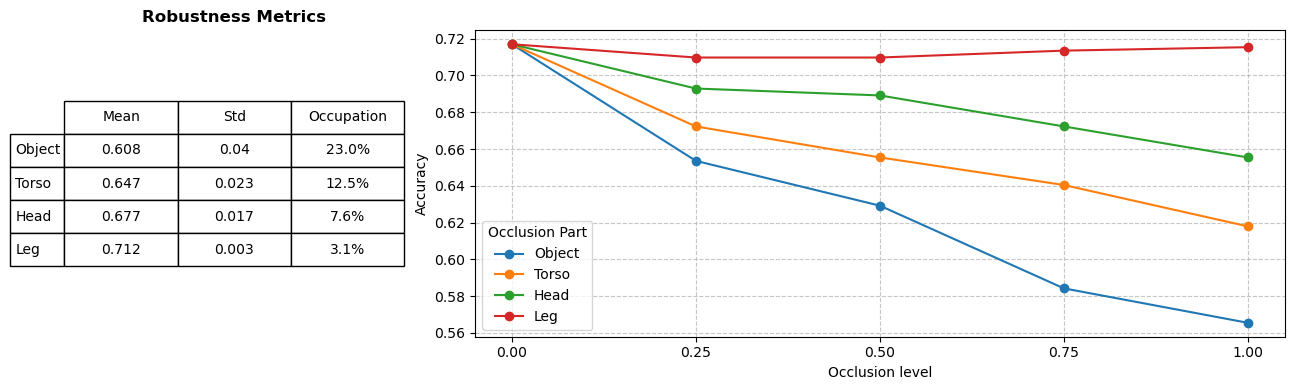

In [12]:
# Valores posibles de porcentaje de oclusión
occlusion_levels = [0.25, 0.5, 0.75, 1]
parts = ['object', 'torso', 'head', 'leg']

# Media base sin oclusión (oc_part == NaN)
base = df[df['oc_part'].isna()]['pred_ok'].mean()

# Diccionario para guardar valores de accuracy
accuracy_data = {}

for part in parts:
    df_part = df[df['oc_part'] == part]
    result = df_part.groupby('oc_part_perc')['pred_ok'].mean().reindex(occlusion_levels)
    result = pd.concat([pd.Series({0: base}), result])
    result = result.sort_index()
    accuracy_data[part] = result

df_acc = pd.DataFrame(accuracy_data)

# Calcular métricas agregadas por parte (mean y std)
summary_table = df_acc.iloc[1:].agg(['mean', 'std']).T.round(3)

# Porcentaje medio de oclusión por parte
occlusion_columns = {
    'object': 'per_occ',
    'torso': 'per_occ_torso',
    'head': 'per_occ_head',
    'leg': 'per_occ_leg'
}
mean_occlusion = [
    df[occlusion_columns[part]].mean() * 100  # convertir a porcentaje
    for part in parts
]
summary_table['Mean % Occlusion'] = [f"{v:.1f}%" for v in mean_occlusion]

# Crear figura
fig, (ax_table, ax_plot) = plt.subplots(1, 2, figsize=(13, 4), gridspec_kw={'width_ratios': [0.7, 2]})

# Tabla de métricas
ax_table.axis('off')
table_data = summary_table.values
column_labels = ['Mean', 'Std', 'Occupation']
row_labels = summary_table.index.str.capitalize()
table = ax_table.table(cellText=table_data, colLabels=column_labels,
                       rowLabels=row_labels, loc='center', cellLoc='center')
table.scale(1.2, 2)
ax_table.set_title("Robustness Metrics", fontsize=12, fontweight='bold')

# Gráfica de líneas
for part in parts:
    ax_plot.plot(df_acc.index, df_acc[part], marker='o', label=part.capitalize())

ax_plot.set_xlabel('Occlusion level')
ax_plot.set_ylabel('Accuracy')
ax_plot.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax_plot.grid(True, linestyle='--', alpha=0.7)
ax_plot.legend(title='Occlusion Part')

plt.tight_layout()
plt.savefig('images/xai_robustness_'+str(OPTION)+'_occlusion_metrics.png')
plt.show()

# Localization

In [13]:
# IoU y mIoU with mask

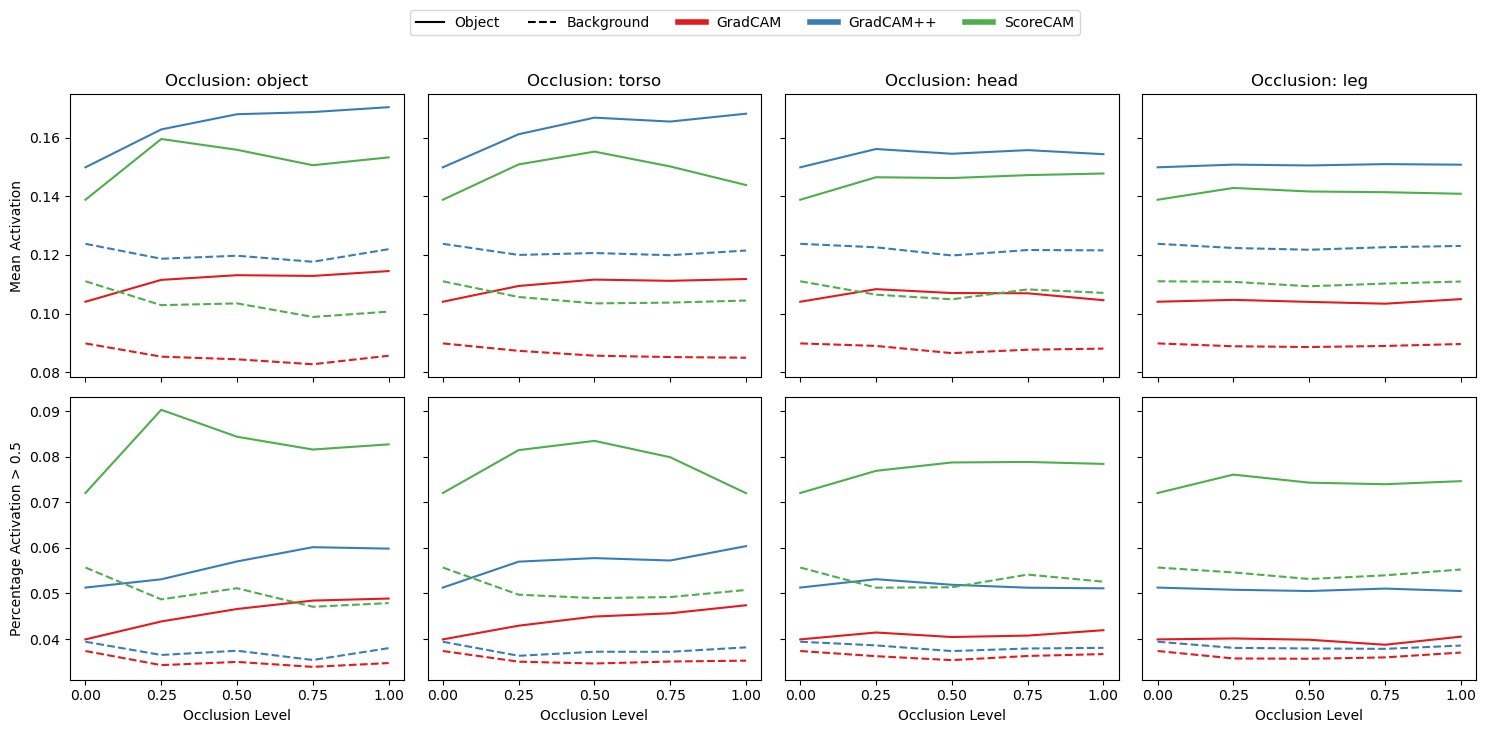

In [14]:
# Crear columna de nivel de oclusión (0 cuando no hay oclusión explícita)
df['occlusion_level'] = df['oc_part_perc']
df.loc[df['oc_part'].isna(), 'occlusion_level'] = 0

# Configuración
occlusion_levels = [0, 0.25, 0.5, 0.75, 1]
parts = ['object', 'torso', 'head', 'leg']
methods = df['method'].unique()

# Figura y ejes compartidos por columna y fila
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7), sharex='col', sharey='row')

linestyles = {'obj': '-', 'back': '--'}
colors = dict(zip(methods, sns.color_palette("Set1", n_colors=len(methods))))

for i, part in enumerate(parts):
    for method in methods:
        df_method = df[df['method'] == method]

        if part == 'object':
            df_sub = df_method[df_method['oc_part'].isna() | (df_method['oc_part'] == 'object')]
        else:
            # Tomar ejemplos donde la parte está ocluida y los NaN como nivel 0
            df_sub = df_method[(df_method['oc_part'] == part) | (df_method['oc_part'].isna())]

        # Forzar oclusión 0.0 para los NaN como nivel de referencia sin oclusión
        df_sub = df_sub.copy()
        df_sub.loc[df_sub['oc_part'].isna(), 'occlusion_level'] = 0

        # Agrupar por nivel de oclusión, asegurando el orden
        grouped = df_sub.groupby('occlusion_level').agg({
            'mean_act_obj': 'mean',
            'mean_act_back': 'mean',
            'perc_act_obj': 'mean',
            'perc_act_back': 'mean'
        }).reindex(occlusion_levels)

        # Fila 1: Activación media
        axes[0, i].plot(grouped.index, grouped['mean_act_obj'], label=f'{method} obj',
                        linestyle=linestyles['obj'], color=colors[method])
        axes[0, i].plot(grouped.index, grouped['mean_act_back'], label=f'{method} back',
                        linestyle=linestyles['back'], color=colors[method])
        axes[0, i].set_title(f'Occlusion: {part}')
        axes[0, i].set_xticks(occlusion_levels)
        if i == 0:
            axes[0, i].set_ylabel('Mean Activation')

        # Fila 2: Porcentaje de activación > 0.5
        axes[1, i].plot(grouped.index, grouped['perc_act_obj'], linestyle=linestyles['obj'],
                        color=colors[method])
        axes[1, i].plot(grouped.index, grouped['perc_act_back'], linestyle=linestyles['back'],
                        color=colors[method])
        axes[1, i].set_xticks(occlusion_levels)
        if i == 0:
            axes[1, i].set_ylabel('Percentage Activation > 0.5')
        axes[1, i].set_xlabel('Occlusion Level')
"""
# Añadir leyenda global
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(methods)*2, bbox_to_anchor=(0.5, 1.05))

# Ajustar márgenes
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
"""
# -------- LEYENDA PERSONALIZADA --------
# Líneas ejemplo
line_obj = Line2D([0], [0], color='black', linestyle='-', label='Object')
line_back = Line2D([0], [0], color='black', linestyle='--', label='Background')

# Colores por método
method_lines = [Line2D([0], [0], color=colors[m], lw=4, label=m) for m in methods]

# Mostrar leyenda
legend_items = [line_obj, line_back] + method_lines
methods_name = ['GradCAM', 'GradCAM++', 'ScoreCAM']
legend_labels = ['Object', 'Background'] + list(methods_name)

fig.legend(legend_items, legend_labels, loc='upper center', ncol=3 + len(methods), bbox_to_anchor=(0.5, 1.05))

# Ajuste final
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig('images/xai_'+str(OPTION)+'_prediction_occlusion_part_activation.png')
plt.show()

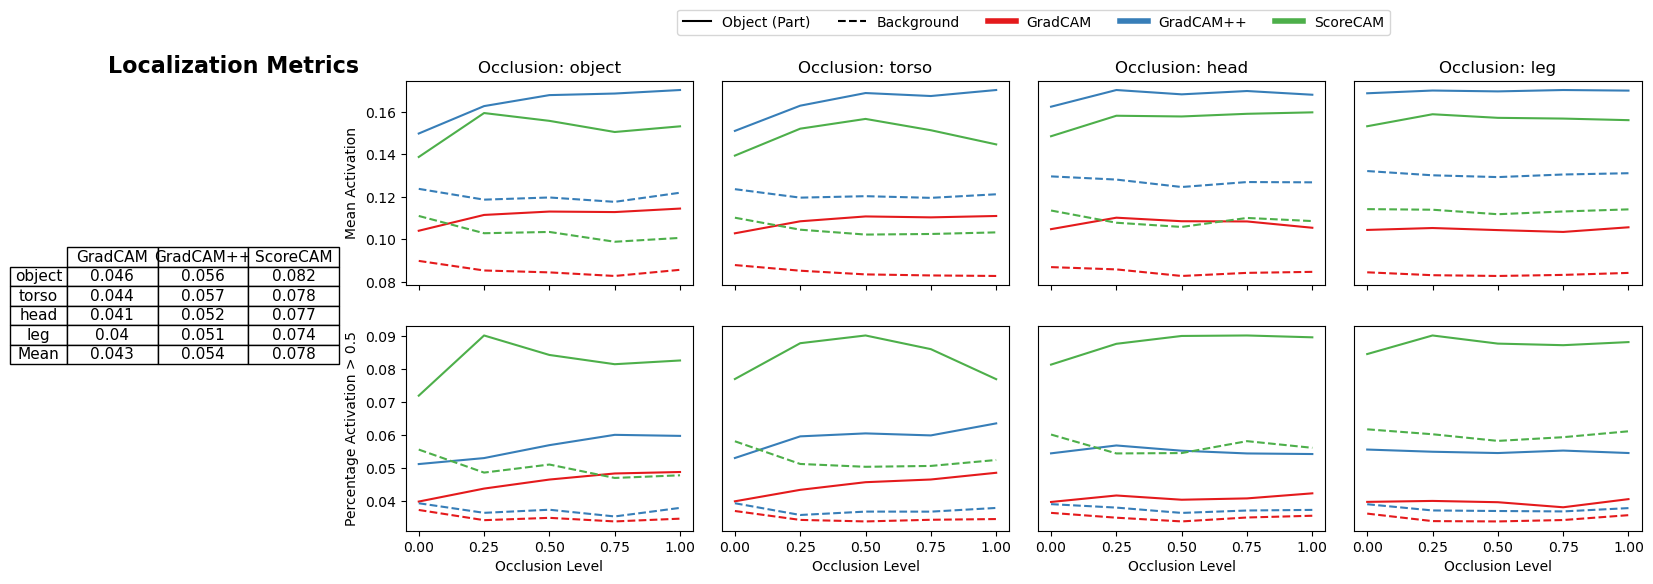

In [15]:
# Crear columna de nivel de oclusión (0 cuando no hay oclusión explícita)
df['occlusion_level'] = df['oc_part_perc']
df.loc[df['oc_part'].isna(), 'occlusion_level'] = 0

occlusion_levels = [0, 0.25, 0.5, 0.75, 1]
parts = ['object', 'torso', 'head', 'leg']
methods = df['method'].unique()

linestyles = {'obj': '-', 'back': '--'}
colors = dict(zip(methods, sns.color_palette("Set1", n_colors=len(methods))))

# --- Calcular tabla IoU: porcentaje de activación promedio (perc_act_obj) por parte y método ---
iou_data = []
for part in parts:
    row = []
    for method in methods:
        df_method = df[df['method'] == method]
        if part == 'object':
            df_sub = df_method[df_method['oc_part'].isna() | (df_method['oc_part'] == 'object')]
        else:
            df_sub = df_method[(df_method['oc_part'] == part) | (df_method['oc_part'].isna())]
        df_sub = df_sub.copy()
        df_sub.loc[df_sub['oc_part'].isna(), 'occlusion_level'] = 0

        mean_perc_act_obj = df_sub['perc_act_obj'].mean()
        row.append(mean_perc_act_obj)
    iou_data.append(row)

iou_df = pd.DataFrame(iou_data, index=parts, columns=methods)
iou_df.loc['Mean'] = iou_df.mean(axis=0)

# --- Crear figura con 2 filas y 5 columnas (columna 0 para tabla, 1-4 para gráficos) ---

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), 
                         gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]},  # primera columna más estrecha
                         sharex='col')  # No compartimos sharey para controlar ticks Y mejor

# Tabla en columna 0
for ax in axes[:, 0]:
    ax.axis('off')

import matplotlib.gridspec as gridspec
gs = fig.add_gridspec(2, 5, width_ratios=[0.75, 1, 1, 1, 1])
ax_table = fig.add_subplot(gs[:, 0])
ax_table.axis('off')

methods_name = ['GradCAM', 'GradCAM++', 'ScoreCAM']
col_labels = methods_name + ['Mean']

# Tabla
table = ax_table.table(
    cellText=np.round(iou_df.values, 3),
    rowLabels=iou_df.index,
    colLabels=col_labels,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.2)
axes[0, 0].set_title('Localization Metrics', fontsize=16, fontweight='bold')


# Gráficos columnas 1-4
for i, part in enumerate(parts):
    for method in methods:
        df_method = df[df['method'] == method]

        if part == 'object':
            df_sub = df_method[df_method['oc_part'].isna() | (df_method['oc_part'] == 'object')]
        else:
            df_sub = df_method[(df_method['oc_part'] == part) | (df_method['oc_part'].isna())]

        df_sub = df_sub.copy()
        df_sub.loc[df_sub['oc_part'].isna(), 'occlusion_level'] = 0

        grouped = df_sub.groupby('occlusion_level').agg({
            'mean_act_obj': 'mean',
            'mean_act_back': 'mean',
            'perc_act_obj': 'mean',
            'perc_act_back': 'mean'
        }).reindex(occlusion_levels)

        ax_top = axes[0, i+1]
        ax_bot = axes[1, i+1]

        ax_top.plot(grouped.index, grouped['mean_act_obj'], label=f'{method} obj',
                    linestyle=linestyles['obj'], color=colors[method])
        ax_top.plot(grouped.index, grouped['mean_act_back'], label=f'{method} back',
                    linestyle=linestyles['back'], color=colors[method])
        ax_top.set_title(f'Occlusion: {part}')
        ax_top.set_xticks(occlusion_levels)

        ax_bot.plot(grouped.index, grouped['perc_act_obj'], linestyle=linestyles['obj'],
                    color=colors[method])
        ax_bot.plot(grouped.index, grouped['perc_act_back'], linestyle=linestyles['back'],
                    color=colors[method])
        ax_bot.set_xticks(occlusion_levels)

        # Solo la columna 1 muestra ticks y etiquetas Y
        if i == 0:
            ax_top.set_ylabel('Mean Activation')
            ax_bot.set_ylabel('Percentage Activation > 0.5')
        else:
            ax_top.set_yticklabels([])
            ax_top.tick_params(left=False)
            ax_bot.set_yticklabels([])
            ax_bot.tick_params(left=False)

        ax_bot.set_xlabel('Occlusion Level')

# Leyenda
line_obj = Line2D([0], [0], color='black', linestyle='-', label='Object')
line_back = Line2D([0], [0], color='black', linestyle='--', label='Background')
method_lines = [Line2D([0], [0], color=colors[m], lw=4, label=m) for m in methods]
legend_items = [line_obj, line_back] + method_lines
methods_name = ['GradCAM', 'GradCAM++', 'ScoreCAM']
legend_labels = ['Object (Part)', 'Background'] + list(methods_name)
fig.legend(legend_items, legend_labels, loc='upper center', ncol=3 + len(methods), bbox_to_anchor=(0.6, 1.03))

#plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(left=0.01, right=0.98, top=0.9, bottom=0.15, wspace=0.1)
plt.savefig('images/xai_localization_'+str(OPTION)+'_iou_metrics.png')
plt.show()

# Agreement-based

In [16]:
# point game -> most salient point in ground-truth region

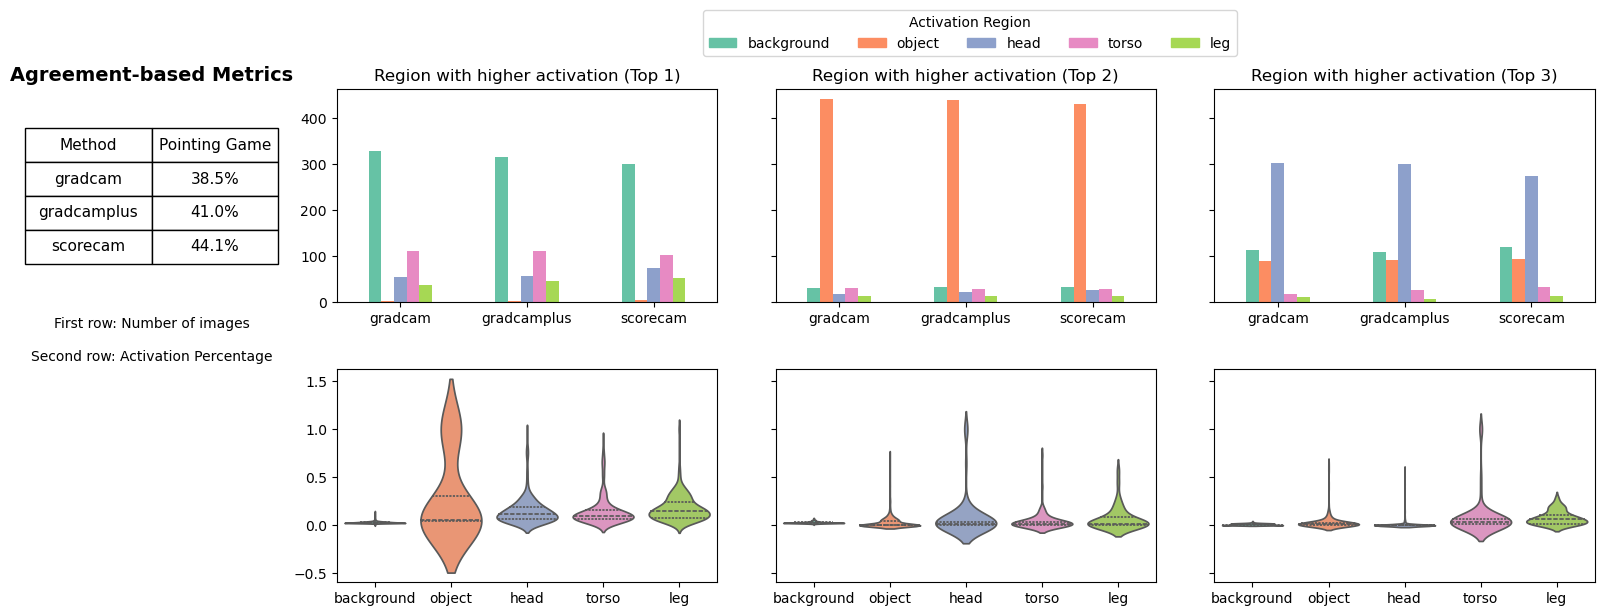

In [17]:
# Filtrar sin oclusión
df_no_occ = df[df['oc_part'].isna()].copy()

# Orden para las categorías
activation_order = ['background', 'object', 'head', 'torso', 'leg']

# Crear un mapa de colores fijo
base_palette = sns.color_palette('Set2', n_colors=len(activation_order))
part_color_map = dict(zip(activation_order, base_palette))

# Columnas y títulos para barras (fila 1)
activation_parts = ['hact_1_part', 'hact_2_part', 'hact_3_part']
titles_parts = ['Region with higher activation (Top 1)', 
                'Region with higher activation (Top 2)', 
                'Region with higher activation (Top 3)']

# Columnas para porcentaje (fila 2)
activation_percs = ['hact_1_perc', 'hact_2_perc', 'hact_3_perc']
titles_percs = ['Activation percentage (Top 1)', 
                'Activation percentage (Top 2)', 
                'Activation percentage (Top 3)']

# -------------------------
# Calcular Pointing Game: porcentaje de veces que la Top-1 es relevante (no background)
df_pg = df_no_occ[['method', 'hact_1_part']].copy()
df_pg['hit'] = df_pg['hact_1_part'].isin(['object', 'head', 'torso', 'leg'])
pg_scores = df_pg.groupby('method')['hit'].mean().sort_index().round(3)
# -------------------------

# Crear figura con 2 filas x 4 columnas (tabla + 3 plots)
fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey='row', gridspec_kw={'width_ratios': [1, 1.5, 1.5, 1.5]})

# Fila 1, columna 0: mostrar tabla Pointing Game
axes[0, 0].axis('off')
pg_table_data = [[method, f"{score*100:.1f}%"] for method, score in pg_scores.items()]
table = axes[0, 0].table(
    cellText=pg_table_data,
    colLabels=['Method', 'Pointing Game'],
    loc='center',
    cellLoc='center',
    colWidths=[0.5, 0.5]
)
table.scale(1, 2)
table.auto_set_font_size(False)
table.set_fontsize(11)
axes[0, 0].set_title('Agreement-based Metrics', fontsize=14, fontweight='bold')

axes[1, 0].set_title('First row: Number of images\n\nSecond row: Activation Percentage', fontsize=10)

# Fila 2, columna 0: sin contenido
axes[1, 0].axis('off')

# Primera fila: barras por método y zona de activación
for i, col in enumerate(activation_parts):
    grouped = df_no_occ.groupby(['method', col]).size().unstack(fill_value=0)
    grouped = grouped[activation_order]
    bar_colors = [part_color_map[part] for part in grouped.columns]
    #grouped.plot(kind='bar', ax=axes[0, i+1], color=bar_colors)
    grouped.plot.bar(ax=axes[0, i+1], color=bar_colors)


    axes[0, i+1].set_title(titles_parts[i])
    axes[0, i+1].set_xlabel('')
    if i == 0:
        axes[0, i+1].set_ylabel('Number of images')
    else:
        axes[0, i+1].set_ylabel('')
    axes[0, i+1].tick_params(axis='x', rotation=0)
    axes[0, i+1].legend().set_visible(False)

# Segunda fila: violinplots de porcentaje por zona topX
for i, (part_col, perc_col) in enumerate(zip(activation_parts, activation_percs)):
    df_no_occ[part_col] = pd.Categorical(df_no_occ[part_col], categories=activation_order, ordered=True)
    df_sub = df_no_occ.dropna(subset=[part_col, perc_col])

    sns.violinplot(
        data=df_sub,
        x=part_col,
        y=perc_col,
        order=activation_order,
        palette=part_color_map,
        hue=part_col,
        legend=False,
        inner='quartile',
        ax=axes[1, i+1]
    )
    axes[1, i+1].set_xlabel('')
    # Asegura visibilidad completa del eje Y en los primeros plots de cada fila
    if i == 0:
        axes[0, i+1].yaxis.set_visible(True)
        axes[0, i+1].tick_params(axis='y', labelleft=True)
    
        axes[1, i+1].yaxis.set_visible(True)
        axes[1, i+1].tick_params(axis='y', labelleft=True)
    # Primera fila
    if i == 0:
        axes[0, i+1].set_ylabel('Number of images')
    else:
        axes[0, i+1].set_ylabel('')
    
    # Segunda fila
    if i == 0:
        axes[1, i+1].set_ylabel('Activation percentage')
    else:
        axes[1, i+1].set_ylabel('')

# Leyenda global
from matplotlib.patches import Patch
legend_patches = [Patch(color=part_color_map[part], label=part) for part in activation_order]
fig.legend(handles=legend_patches, title='Activation Region', loc='upper center', ncol=len(activation_order), bbox_to_anchor=(0.6, 1.03))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/xai_agreement_'+str(OPTION)+'_higher_activation_region_metrics.png')
plt.show()